<a href="https://colab.research.google.com/github/kritinkesavkts/Deeplearningclass/blob/main/Travel_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Load datasets
destinations = pd.read_csv('https://raw.githubusercontent.com/kritinkesavkts/Deeplearningclass/main/Expanded_Destinations.csv')
reviews = pd.read_csv('https://raw.githubusercontent.com/kritinkesavkts/Deeplearningclass/main/Final_Updated_Expanded_Reviews.csv')
user_history = pd.read_csv('https://raw.githubusercontent.com/kritinkesavkts/Deeplearningclass/main/Final_Updated_Expanded_UserHistory.csv')
users = pd.read_csv('https://raw.githubusercontent.com/kritinkesavkts/Deeplearningclass/main/Final_Updated_Expanded_Users.csv')

# Initialize and download VADER for sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
reviews['Sentiment'] = reviews['ReviewText'].apply(lambda text: sia.polarity_scores(text)['compound'])

# Categorize sentiment into positive, neutral, and negative based on the compound score
def categorize_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'
reviews['Sentiment'] = reviews['Sentiment'].apply(categorize_sentiment)

# Merge datasets for a comprehensive view
data = reviews.merge(users, on='UserID')
data = data.merge(destinations, on='DestinationID', suffixes=('_user', '_dest'))
data = data.merge(user_history, on=['UserID', 'DestinationID'], how='left', suffixes=('', '_hist'))


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
data.head()

,ReviewID,DestinationID,UserID,Rating,ReviewText,Sentiment,Name_user,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren,Name_dest,State,Type,Popularity,BestTimeToVisit,HistoryID,VisitDate,ExperienceRating
0,1,178,327,2,Incredible monument!,neutral,Pooja,pooja@example.com,"City, Historical",Female,1,1,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,NaN,NaN,NaN
1,293,178,653,5,Loved the beaches!,positive,Aarav,aarav@example.com,"Nature, Adventure",Male,2,1,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,NaN,NaN,NaN
2,610,106,327,2,Incredible monument!,neutral,Pooja,pooja@example.com,"City, Historical",Female,1,1,Taj Mahal,Uttar Pradesh,Historical,8.494824,Nov-Feb,NaN,NaN,NaN
3,418,106,708,3,Incredible monument!,neutral,Dhruv,dhruv@example.com,"City, Historical",Male,1,1,Taj Mahal,Uttar Pradesh,Historical,8.494824,Nov-Feb,NaN,NaN,NaN
4,2,411,783,1,Loved the beaches!,positive,Karan,karan@example.com,"City, Historical",Male,1,1,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,NaN,NaN,NaN


<ipython-input-3-d148f273456f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')


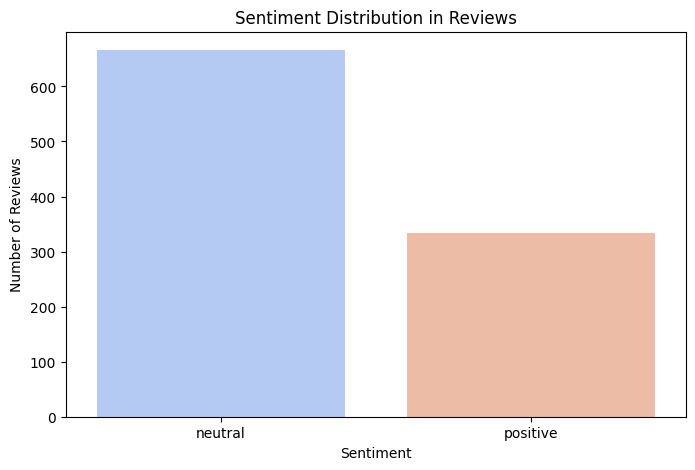

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


sentiment_counts = reviews['Sentiment'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='coolwarm')
plt.title('Sentiment Distribution in Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


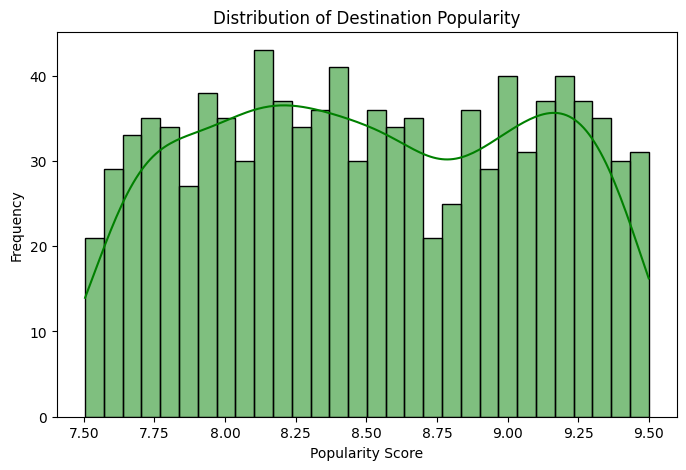

In [ ]:
# Assuming 'destinations' dataframe has a 'Popularity' column
plt.figure(figsize=(8, 5))
sns.histplot(destinations['Popularity'], bins=30, kde=True, color='green')
plt.title('Distribution of Destination Popularity')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create separate encoders for each category
user_encoder = LabelEncoder()
destination_encoder = LabelEncoder()
sentiment_encoder = LabelEncoder()

# Fit and transform with separate encoders
data['User_ID_Encoded'] = user_encoder.fit_transform(data['UserID'])
data['Dest_ID_Encoded'] = destination_encoder.fit_transform(data['DestinationID'])
data['Sentiment_Encoded'] = sentiment_encoder.fit_transform(data['Sentiment'])


<ipython-input-6-66eb783a287e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=reviews, palette='viridis')


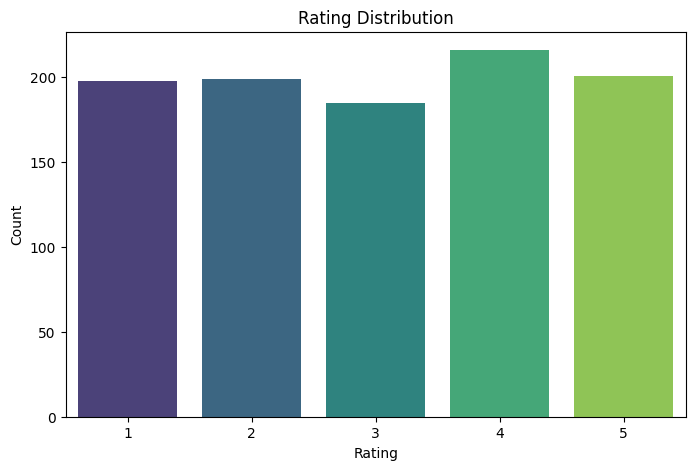

In [ ]:
# Assuming 'reviews' dataframe has a 'Rating' column
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=reviews, palette='viridis')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout

num_users = data['User_ID_Encoded'].nunique()
num_destinations = data['Dest_ID_Encoded'].nunique()

# Input layers
user_input = Input(shape=(1,), name='user_input')
destination_input = Input(shape=(1,), name='destination_input')
sentiment_input = Input(shape=(1,), name='sentiment_input')

# Embeddings
user_embedding = Embedding(num_users, 50, input_length=1, name='user_embedding')(user_input)
destination_embedding = Embedding(num_destinations, 50, input_length=1, name='destination_embedding')(destination_input)
sentiment_embedding = Embedding(3, 10, input_length=1, name='sentiment_embedding')(sentiment_input)

# Flatten the embeddings
user_vec = Flatten()(user_embedding)
destination_vec = Flatten()(destination_embedding)
sentiment_vec = Flatten()(sentiment_embedding)

# Concatenate all vectors
concat = concatenate([user_vec, destination_vec, sentiment_vec])

# Dense layers
dense = Dense(128, activation='relu')(concat)
dropout = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(dropout)

# Model definition
model = Model(inputs=[user_input, destination_input, sentiment_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout

# Prepare data for training and evaluation
X = data[['User_ID_Encoded', 'Dest_ID_Encoded', 'Sentiment_Encoded']]
y = (data['Rating'] > 3).astype(int)  # Binary classification of ratings

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




**Run only this under fit function for basic model and skip the next fit model and continue **

In [ ]:
# Train the model
history = model.fit([X_train['User_ID_Encoded'], X_train['Dest_ID_Encoded'], X_train['Sentiment_Encoded']], y_train, epochs=20, batch_size=64, validation_data=([X_test['User_ID_Encoded'], X_test['Dest_ID_Encoded'], X_test['Sentiment_Encoded']], y_test))

Epoch 1/20
13/13 [==============================] - 2s 25ms/step - loss: 0.6908 - accuracy: 0.5469 - val_loss: 0.6869 - val_accuracy: 0.5850
Epoch 2/20
13/13 [==============================] - 0s 7ms/step - loss: 0.6763 - accuracy: 0.5832 - val_loss: 0.6822 - val_accuracy: 0.5850
Epoch 3/20
13/13 [==============================] - 0s 8ms/step - loss: 0.6627 - accuracy: 0.5832 - val_loss: 0.6783 - val_accuracy: 0.5850
Epoch 4/20
13/13 [==============================] - 0s 7ms/step - loss: 0.6388 - accuracy: 0.5882 - val_loss: 0.6760 - val_accuracy: 0.5850
Epoch 5/20
13/13 [==============================] - 0s 7ms/step - loss: 0.5899 - accuracy: 0.6746 - val_loss: 0.6758 - val_accuracy: 0.6050
Epoch 6/20
13/13 [==============================] - 0s 6ms/step - loss: 0.5017 - accuracy: 0.8310 - val_loss: 0.6868 - val_accuracy: 0.5800
Epoch 7/20
13/13 [==============================] - 0s 7ms/step - loss: 0.3743 - accuracy: 0.9299 - val_loss: 0.7319 - val_accuracy: 0.5350
Epoch 8/20
13/13 [=

**Run Only this For early stopping model dont run the above fit function and continue **

In [ ]:
from keras.callbacks import EarlyStopping

# Initialize EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit([X_train['User_ID_Encoded'], X_train['Dest_ID_Encoded'], X_train['Sentiment_Encoded']],
                    y_train,
                    epochs=50,  # Increased epochs but will stop early if val_accuracy stops improving
                    batch_size=64,
                    validation_data=([X_test['User_ID_Encoded'], X_test['Dest_ID_Encoded'], X_test['Sentiment_Encoded']], y_test),
                    callbacks=[early_stopping])


Epoch 1/50
13/13 [==============================] - 1s 26ms/step - loss: 0.6869 - accuracy: 0.5757 - val_loss: 0.6861 - val_accuracy: 0.5850
Epoch 2/50
13/13 [==============================] - 0s 8ms/step - loss: 0.6746 - accuracy: 0.5845 - val_loss: 0.6825 - val_accuracy: 0.5850
Epoch 3/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6577 - accuracy: 0.5832 - val_loss: 0.6802 - val_accuracy: 0.5850
Epoch 4/50
13/13 [==============================] - 0s 7ms/step - loss: 0.6273 - accuracy: 0.6008 - val_loss: 0.6787 - val_accuracy: 0.5850
Epoch 5/50
13/13 [==============================] - 0s 6ms/step - loss: 0.5701 - accuracy: 0.7084 - val_loss: 0.6800 - val_accuracy: 0.5850
Epoch 6/50
13/13 [==============================] - 0s 9ms/step - loss: 0.4786 - accuracy: 0.8561 - val_loss: 0.6911 - val_accuracy: 0.5750


7/7 [==============================] - 0s 2ms/step


<Figure size 800x800 with 0 Axes>

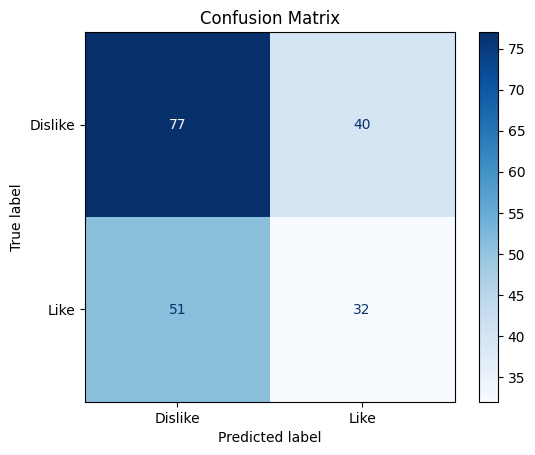

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predicting the test dataset
y_pred = model.predict([X_test['User_ID_Encoded'], X_test['Dest_ID_Encoded'], X_test['Sentiment_Encoded']])
y_pred = (y_pred > 0.5).astype(int)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dislike', 'Like'])

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
disp.plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import numpy as np

def recommend_destinations(user_id, top_n=5):
    user_idx = np.array([user_encoder.transform([user_id])]*num_destinations)
    dest_idx = np.array(range(num_destinations))
    sentiment_idx = np.array([1]*num_destinations)  # Assume neutral sentiment for prediction

    # Predict liking probabilities
    predictions = model.predict([user_idx.flatten(), dest_idx, sentiment_idx])

    # Get top N destinations
    top_indices = predictions.flatten().argsort()[-top_n:][::-1]
    top_dest_ids = destination_encoder.inverse_transform(top_indices)
    top_dest_names = destinations.loc[destinations['DestinationID'].isin(top_dest_ids), 'Name']

    return top_dest_names

# Example usage
test_user_id = user_encoder.classes_[0]  # Using the first user ID known to the encoder
print("Recommendations for User ID:", test_user_id)
print(recommend_destinations(test_user_id))


Recommendations for User ID: 2
21/21 [==============================] - 0s 2ms/step
46     Goa Beaches
109     Leh Ladakh
179     Leh Ladakh
335      Taj Mahal
989     Leh Ladakh
Name: Name, dtype: object


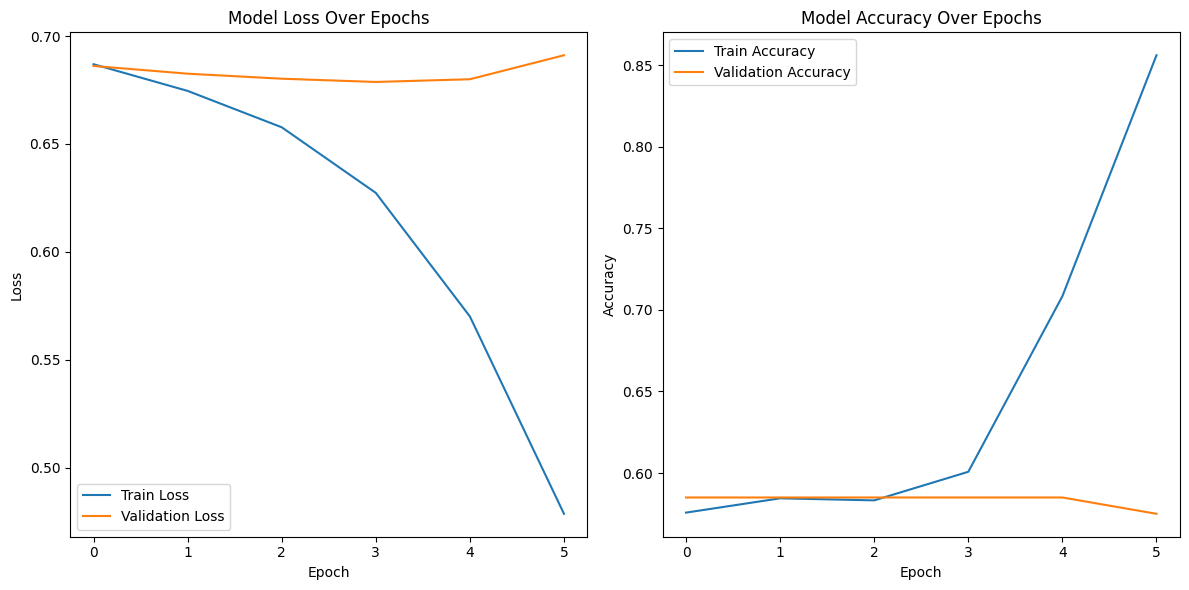

In [ ]:
# Assuming 'history' is the output from model.fit()
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_test['User_ID_Encoded'], X_test['Dest_ID_Encoded'], X_test['Sentiment_Encoded']], y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


7/7 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5850
Test Accuracy: 58.50%


7/7 [==============================] - 0s 2ms/step
Accuracy: 58.50%


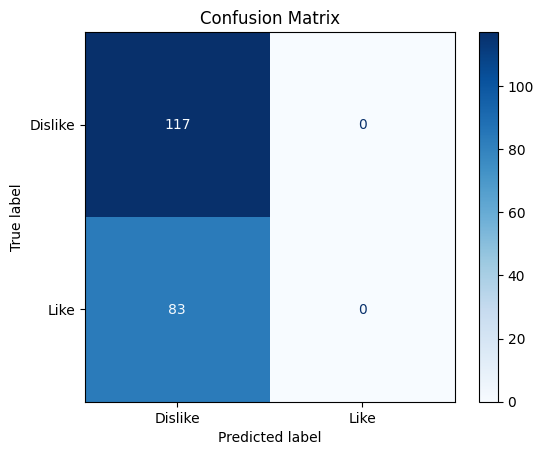

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predictions
y_pred = model.predict([X_test['User_ID_Encoded'], X_test['Dest_ID_Encoded'], X_test['Sentiment_Encoded']])
y_pred = (y_pred > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Dislike', 'Like'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Precision, Recall, and F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


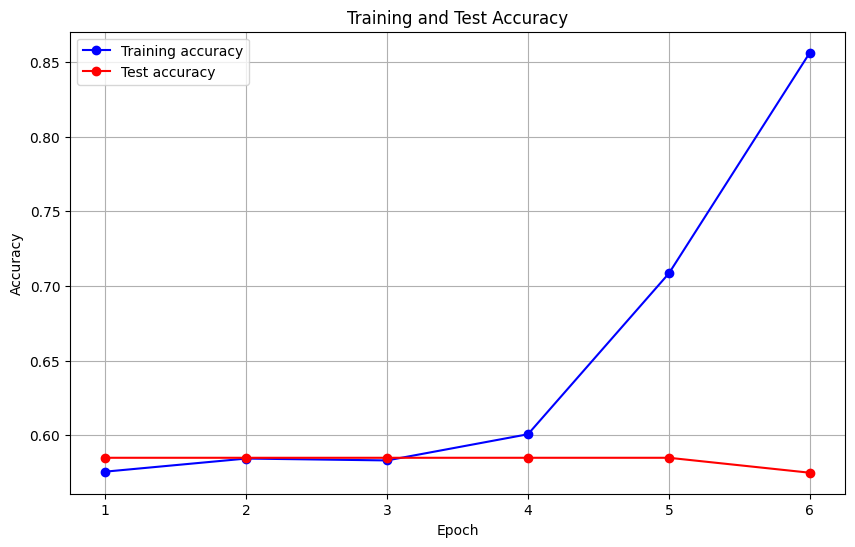

In [ ]:
import matplotlib.pyplot as plt

# Access the history to retrieve training and test accuracies
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Test accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
